In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

d:\College\III_year_II_part\WDSS\jupyter_notebooks
d:\College\III_year_II_part\WDSS


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

import tqdm

from typing import List, Tuple, Dict

from config import device, Settings
from commons import initialize

In [3]:
settings = Settings("config/config.json", "WDSSV5")
initialize(settings=settings)

Job: circle, Model: WDSSV5, Device: cuda
Model path: out\circle-WDSSV5\model
Log path: out\circle-WDSSV5\logs


In [25]:
from network.dataset import *

# Load the dataset
dataset = WDSSDatasetCompressed(settings.train_dir, 119)

# Load the raw frames
raw_frames = dataset._get_raw_frames(470, True)

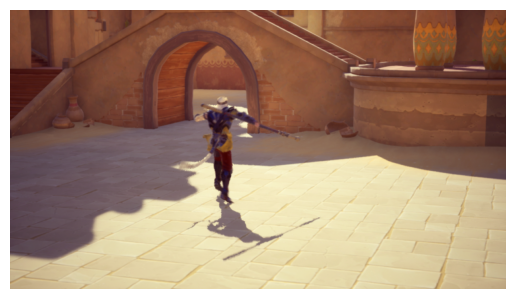

In [26]:
hr = raw_frames[RawFrameGroup.HR]
ImageUtils.display_image(hr)

In [24]:
hr_images = []
for i in tqdm.tqdm(range(len(dataset))):
    raw_frames = dataset._get_raw_frames(i, True)
    image = raw_frames[RawFrameGroup.HR].cpu().numpy().transpose(1, 2, 0)
    hr_images.append(image)

# Calculate the average frequency for each hr image
avg_frequencies = []

for image in tqdm.tqdm(hr_images):
    # Calculate the Fourier transform of the image
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # Calculate the magnitude spectrum
    magnitude_spectrum = np.abs(f_transform_shifted)
    
    # Calculate the average frequency
    avg_frequency = np.mean(magnitude_spectrum)
    avg_frequencies.append(avg_frequency)

# Find the frame with the highest and lowest average frequency
max_avg_freq_index = np.argmax(avg_frequencies)
min_avg_freq_index = np.argmin(avg_frequencies)

print(f"Frame with highest average frequency: {max_avg_freq_index}")
print(f"Frame with lowest average frequency: {min_avg_freq_index}")

  0%|          | 0/476 [00:00<?, ?it/s]

100%|██████████| 476/476 [01:31<00:00,  5.21it/s]


Frame with highest average frequency: 238
Frame with lowest average frequency: 11


In [64]:
raw_frames = dataset._get_raw_frames(9, True)
gbuffers = raw_frames[RawFrameGroup.HR_GB]

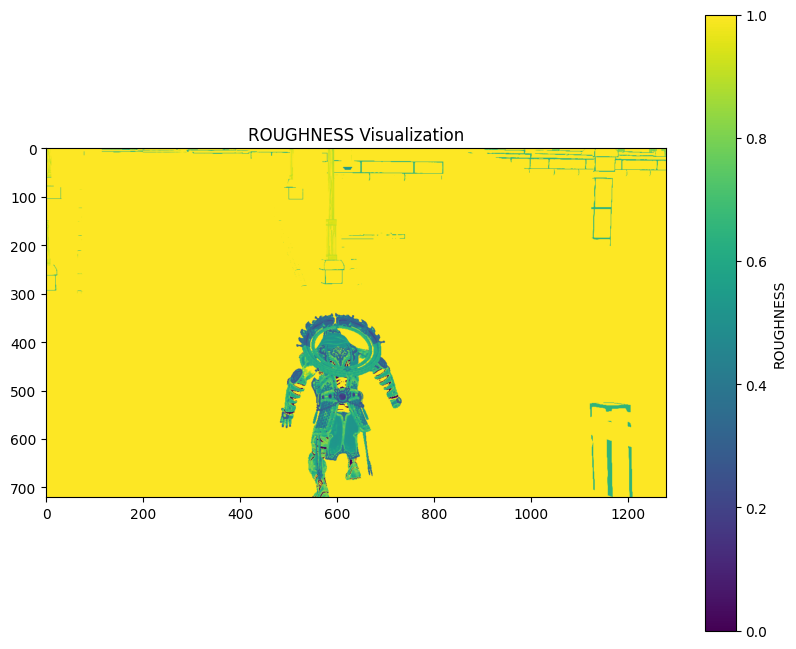

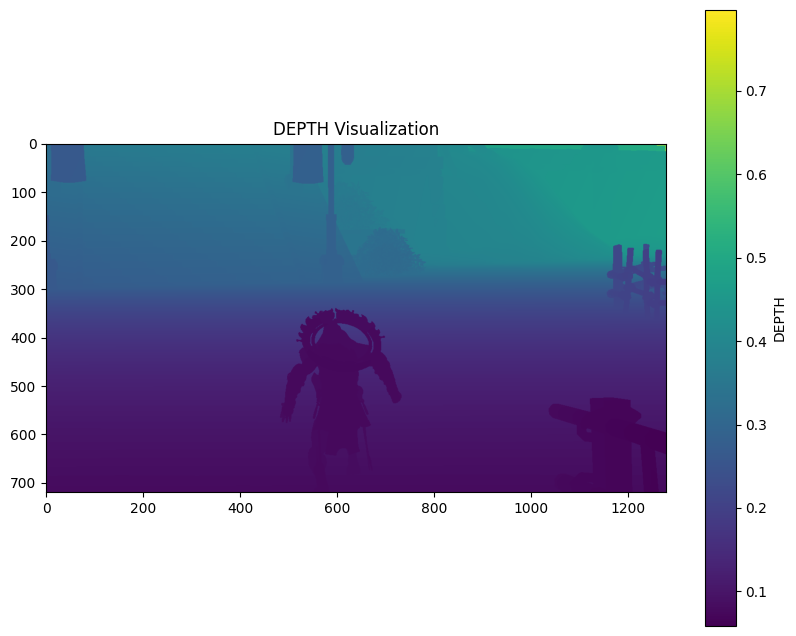

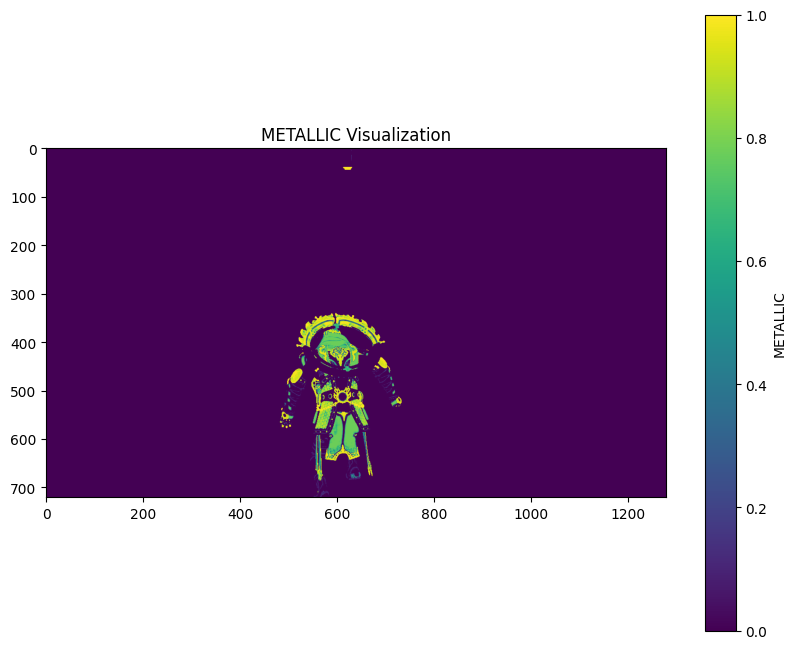

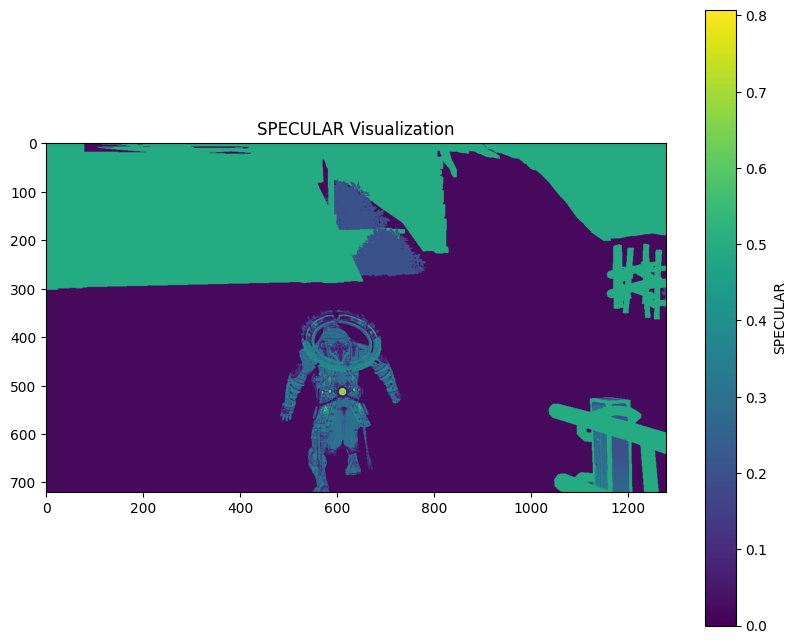

In [111]:
def visualize_gbuffer_channel(gbuffers, channel_type, title):
    # Convert the tensor to a numpy array
    channel_np = gbuffers[channel_type].cpu().numpy()

    # Plot the data without changing the color
    plt.figure(figsize=(10, 8))
    plt.imshow(channel_np[0], cmap=None)
    plt.colorbar(label=channel_type.name)
    plt.title(title)
    plt.show()


channel = [GB_Type.ROUGHNESS, GB_Type.DEPTH, GB_Type.METALLIC, GB_Type.SPECULAR]
# Example usage:
for channel_type in channel:
    visualize_gbuffer_channel(gbuffers, channel_type, f'{channel_type.name} Visualization')


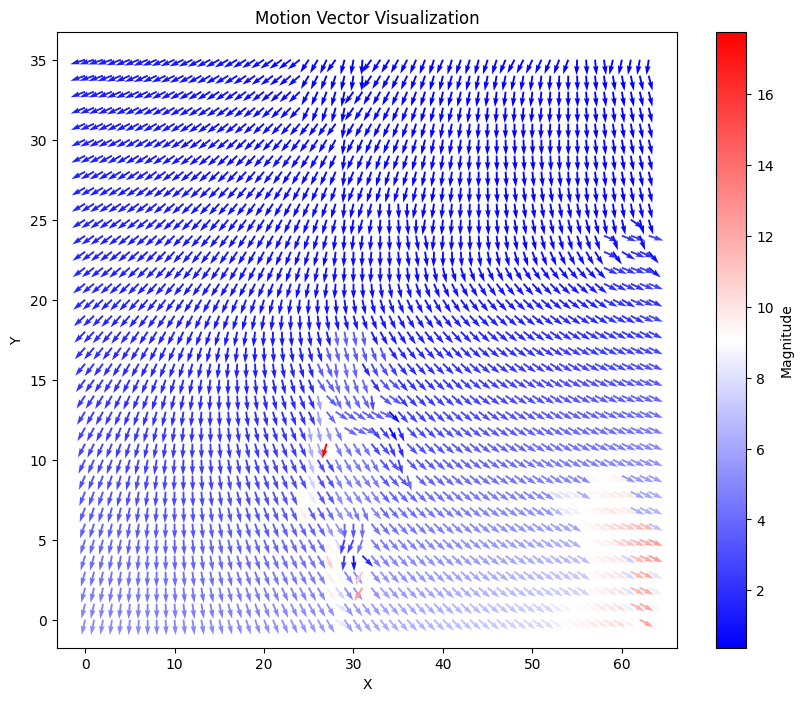

In [66]:

def visualize_motion_vector(motion_vector, title):
    # Convert the tensor to a numpy array
    motion_vector = ImageUtils.upsample(motion_vector.unsqueeze(0), 0.05).squeeze(0)
    motion_vector_np = motion_vector.cpu().numpy()

    # Extract the horizontal and vertical components of the motion vector
    u = motion_vector_np[0]
    v = motion_vector_np[1]

    # Flip the motion vector image horizontally
    u = np.flipud(u)
    v = np.flipud(v)

    # Create a grid of coordinates
    x = np.arange(0, u.shape[1])
    y = np.arange(0, u.shape[0])
    x, y = np.meshgrid(x, y)

    # Normalize the motion vectors to keep the arrow length equal
    magnitude = np.sqrt(u**2 + v**2)
    u_normalized = u / (magnitude + 1e-5)
    v_normalized = v / (magnitude + 1e-5)

    # Plot the motion vectors using quiver with thicker, more continuous lines
    plt.figure(figsize=(10, 8))
    quiver = plt.quiver(
        x,
        y,
        u_normalized,
        v_normalized,
        magnitude,
        scale=40,  # Lower scale for more continuous arrows
        width=0.003,  # Increase width for thicker lines
        cmap=plt.cm.bwr,
    )
    plt.colorbar(quiver, label='Magnitude')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Example usage:
motion_vector = gbuffers[GB_Type.MOTION_VECTOR]
visualize_motion_vector(motion_vector, 'Motion Vector Visualization')



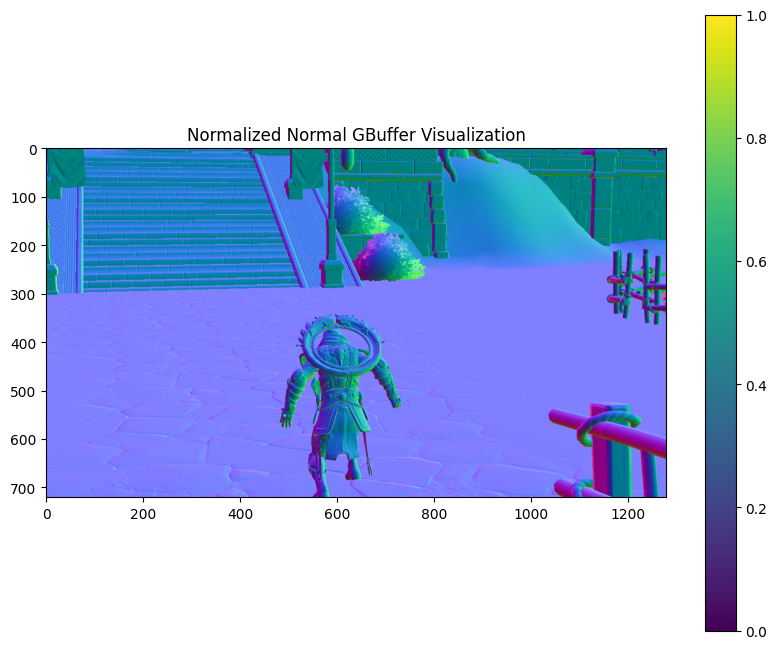

In [68]:
def visualize_normal_gbuffer(normal_gbuffer, title):
    # Convert the tensor to a numpy array
    normal_np = normal_gbuffer.cpu().numpy().transpose(1, 2, 0)
    
    # Normalize the normal map to the range [0, 1]
    normal_np = (normal_np - normal_np.min()) / (normal_np.max() - normal_np.min())

    # Plot the normal map
    plt.figure(figsize=(10, 8))
    plt.imshow(normal_np)
    plt.colorbar()
    plt.title(title)
    plt.show()

# Example usage:
normal_gbuffer = gbuffers[GB_Type.NORMAL]
visualize_normal_gbuffer(normal_gbuffer, 'Normalized Normal GBuffer Visualization')


In [96]:
# Extract the channels from the gbuffers
roughness = gbuffers[GB_Type.ROUGHNESS].cpu().numpy().flatten()
metallic = gbuffers[GB_Type.METALLIC].cpu().numpy().flatten()
specular = gbuffers[GB_Type.SPECULAR].cpu().numpy().flatten()
depth = gbuffers[GB_Type.DEPTH].cpu().numpy().flatten()

def plot_histogram(data, bins, color, xlabel, ylabel, ax):
    ax.hist(data, bins=bins, color=color, edgecolor='black', log=True)  # Always log scale
    ax.set_xlabel(xlabel)
    ax.set_ylabel(f'{ylabel} (log scale)')


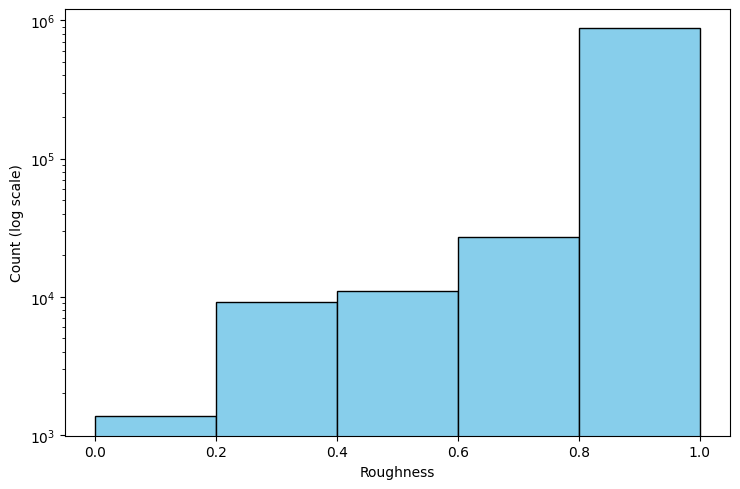

In [112]:
# Create a histogram for the roughness channel using the general function
fig, ax = plt.subplots(figsize=(7.5, 5))

plot_histogram(roughness, bins=np.arange(0, 1.2, 0.2), color='skyblue', xlabel='Roughness', ylabel='Count', ax=ax)

plt.tight_layout()
plt.show()


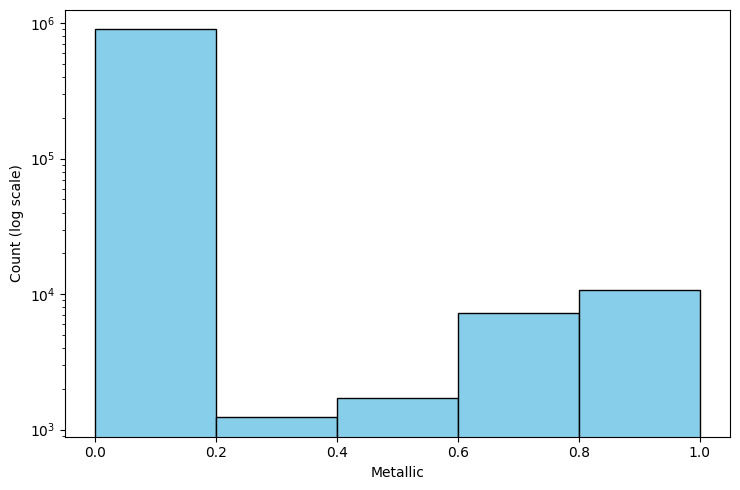

In [114]:
# Create a histogram for the roughness channel using the general function
fig, ax = plt.subplots(figsize=(7.5, 5))

plot_histogram(metallic, bins=np.arange(0, 1.2, 0.2), color='skyblue', xlabel='Metallic', ylabel='Count', ax=ax)

plt.tight_layout()
plt.show()

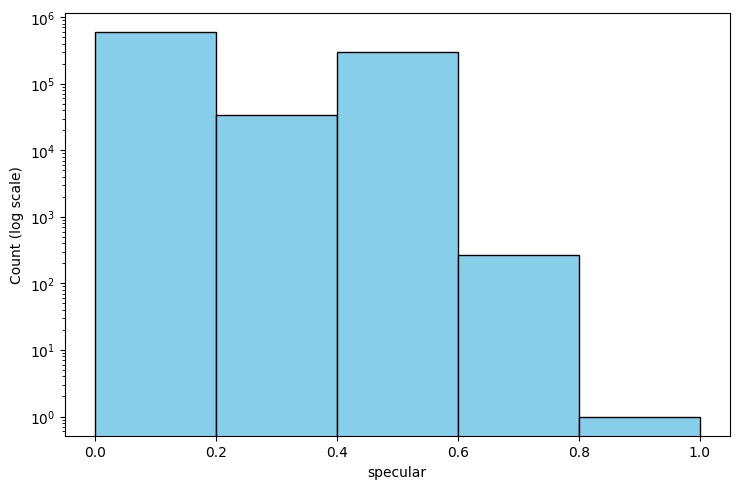

In [115]:
# Create a histogram for the roughness channel using the general function
fig, ax = plt.subplots(figsize=(7.5, 5))

plot_histogram(specular, bins=np.arange(0, 1.2, 0.2), color='skyblue', xlabel='specular', ylabel='Count', ax=ax)

plt.tight_layout()
plt.show()

In [105]:
raw_frames_1 = dataset._get_raw_frames(238, True)
hr_1 = raw_frames_1[RawFrameGroup.HR]


raw_frames_2 = dataset._get_raw_frames(11, True)
hr_2 = raw_frames_2[RawFrameGroup.HR]

In [106]:
def visualize_3d_frequency_domain(tensor, title):
    # Convert the tensor to a numpy array
    tensor_np = tensor.cpu().numpy()

    # Plot the original image using matplotlib
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    ax1.imshow(tensor_np.transpose(1, 2, 0))
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Calculate the Fourier transform of the tensor
    f_transform = np.fft.fft2(tensor_np)
    f_transform_shifted = np.fft.fftshift(f_transform)

    # Calculate the magnitude spectrum and apply logarithmic transformation
    magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)

    # Create coordinate grids
    x = np.arange(magnitude_spectrum.shape[2])
    y = np.arange(magnitude_spectrum.shape[1])
    X, Y = np.meshgrid(x, y)

    # Create a new figure for the 3D plot using matplotlib
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_surface(X, Y, magnitude_spectrum[0], cmap='jet')

    # Set plot labels and title
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.set_zlabel('Log Frequency Magnitude')
    ax2.set_title(title)

    # Add colorbar
    fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)

    # Show the plot
    plt.show()

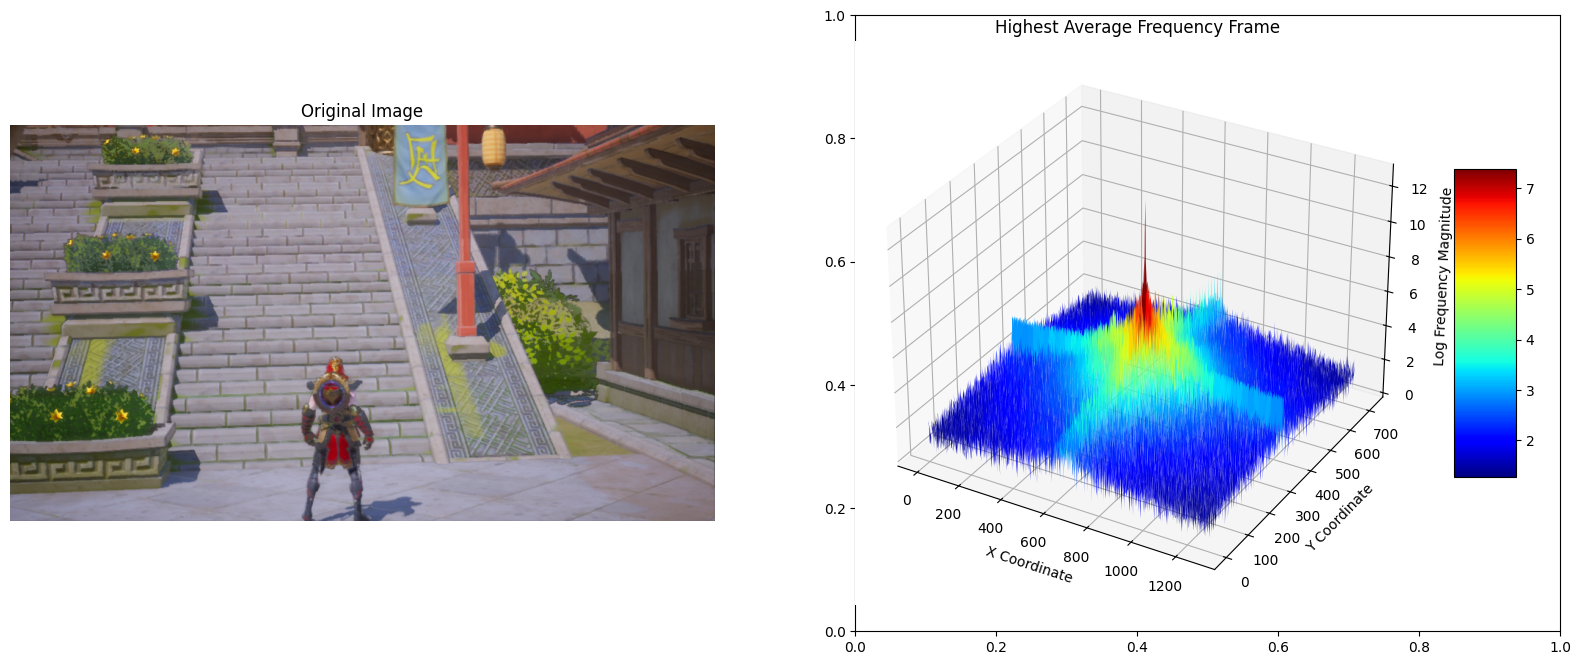

In [107]:
visualize_3d_frequency_domain(hr_1, "Highest Average Frequency Frame")

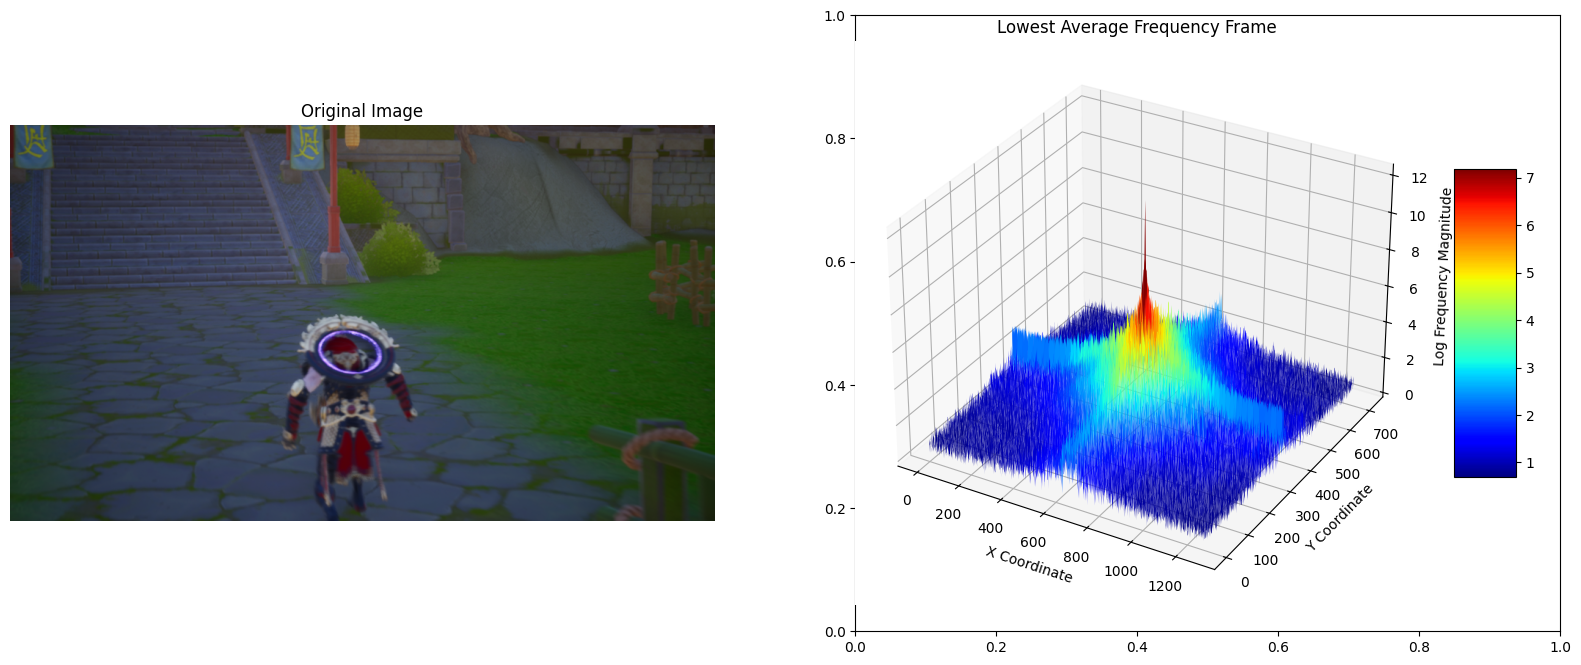

In [108]:
visualize_3d_frequency_domain(hr_2, "Lowest Average Frequency Frame")